# 引言
前面我们讲完交通标志🚥的识别，现在我们开始尝试来实现交通信号灯的识别
接下来我们将按照自己的思路来实现并完善整个Project
# Step 1
首先我们第一步是导入数据，并在RGB及HSV色彩空间可视化部分数据。这里的数据，我们采用[MIT自动驾驶课程](https://selfdrivingcars.mit.edu/)的图片，
总共三类：红绿黄，1187张图片，其中，723张红色交通灯图片，429张绿色交通灯图片，35张黄色交通灯图片。
# 导入库

In [1]:
# import some libs
import cv2
import os
import glob
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [2]:
# Image data directories
IMAGE_DIR_TRAINING = "traffic_light_images/training/"
IMAGE_DIR_TEST = "traffic_light_images/test/"

#load data
def load_dataset(image_dir):
    '''
    This function loads in images and their labels and places them in a list
    image_dir:directions where images stored
    '''
    im_list =[]
    image_types= ['red','yellow','green']
    
    #Iterate through each color folder
    for im_type in image_types:
        file_lists = glob.glob(os.path.join(image_dir,im_type,'*'))
        print(len(file_lists))
        for file in file_lists:
            im = mpimg.imread(file)
            
            if not im is None:
                im_list.append((im,im_type))
    return im_list
IMAGE_LIST = load_dataset(IMAGE_DIR_TRAINING)

723
35
429


# Visualize the data 
这里可视化主要实现：
>* 显示图像
>* 打印出图片的大小
>* 打印出图片对应的标签


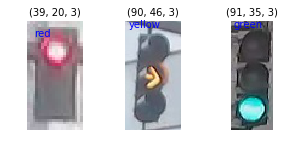

In [3]:
_,ax = plt.subplots(1,3,figsize=(5,2))
#red
img_red = IMAGE_LIST[0][0]
ax[0].imshow(img_red)
ax[0].annotate(IMAGE_LIST[0][1],xy=(2,5),color='blue',fontsize='10')
ax[0].axis('off')
ax[0].set_title(img_red.shape,fontsize=10)
#yellow
img_yellow = IMAGE_LIST[730][0]
ax[1].imshow(img_yellow)
ax[1].annotate(IMAGE_LIST[730][1],xy=(2,5),color='blue',fontsize='10')
ax[1].axis('off')
ax[1].set_title(img_yellow.shape,fontsize=10)
#green
img_green = IMAGE_LIST[800][0]
ax[2].imshow(img_green)
ax[2].annotate(IMAGE_LIST[800][1],xy=(2,5),color='blue',fontsize='10')
ax[2].axis('off')
ax[2].set_title(img_green.shape,fontsize=10)
plt.show()

# PreProcess Data
在导入了上述数据后，接下来我们需要标准化输入及输出
## Input
从上图，我们可以看出，每张图片的大小并不一样，我们需要标准化输入
将每张图图片的大小resize成相同的大小，
因为对于分类任务来说，我们需要
在每张图片上应用相同的算法，因此标准化图像尤其重要
## Output
这里我们的标签数据是类别数据：'red','yellow','green'，因此我们可以利用[one_hot](https://machinelearningmastery.com/how-to-one-hot-encode-sequence-data-in-python/)方法将类别数据转换成数值数据


In [4]:
# 标准化输入图像，这里我们resize图片大小为32x32x3,这里我们也可以对图像进行裁剪、平移、旋转
def standardize(image_list):
    '''
    This function takes a rgb image as input and return a standardized version
    image_list: image and label
    '''
    standard_list = []
    #Iterate through all the image-label pairs
    for item in image_list:
        image = item[0]
        label = item[1]
        # Standardize the input
        standardized_im = standardize_input(image)
        # Standardize the output(one hot)
        one_hot_label = one_hot_encode(label)
        # Append the image , and it's one hot encoded label to the full ,processed list of image data
        standard_list.append((standardized_im,one_hot_label))
    return standard_list

def standardize_input(image):
    #Resize all images to be 32x32x3
    standard_im = cv2.resize(image,(32,32))
    return standard_im

def one_hot_encode(label):
    #return the correct encoded label. 
    '''
    # one_hot_encode("red") should return: [1, 0, 0]
    # one_hot_encode("yellow") should return: [0, 1, 0]
    # one_hot_encode("green") should return: [0, 0, 1]
    '''
    if label=='red':
        return [1,0,0]
    elif label=='yellow':
        return [0,1,0]
    else:
        return [0,0,1]


# Test your code
实现完了上述标准化代码后，我们需要进一步确定我们的代码是正确的，因此接下来我们可以实现一个函数来实现上述代码功能的检验
用Python搭建自动化测试框架，我们需要组织用例以及测试执行，这里我们推荐Python的标准库——unittest。

In [5]:
import unittest
from IPython.display import Markdown,display

# Helper function for printing markdown text(text in color/bold/etc)
def printmd(string):
    display(Markdown(string))
# Print a test falied message,given an error
def print_fail():
    printmd('**<span style=="color: red;">Test Failed</span>**')
def print_pass():
    printmd('**<span style="color:green;">Test Passed</span>**')
# A class holding all tests
class Tests(unittest.TestCase):
    #Tests the 'one_hot_encode' function,which is passed in as an argument
    def test_one_hot(self,one_hot_function):
        #test that the generate onr-hot lables match the expected one-hot label
        #for all three cases(red,yellow,green)
        try:
            self.assertEqual([1,0,0],one_hot_function('red'))
            self.assertEqual([0,1,0],one_hot_function('yellow'))
            self.assertEqual([0,0,1],one_hot_function('green'))
        #enter exception
        except self.failureException as e:
            #print out an error message
            print_fail()
            print('Your function did not return the excepted one-hot label')
            print('\n'+str(e))
            return
        print_pass()
    #Test if ay misclassified images are red but mistakenly classifed as green
    def test_red_aa_green(self,misclassified_images):
        #Loop through each misclassified image and the labels
        for im,predicted_label,true_label in misclassified_images:
            #check if the iamge is one of a red light
            if(true_label==[1,0,0]):
                try:
                    self.assertNotEqual(true_label,[0,1,0])
                except self.failureException as e:
                    print_fail()
                    print('Warning:A red light is classified as green.')
                    print('\n'+str(e))
                    return
        print_pass()
tests = Tests()
tests.test_one_hot(one_hot_encode)

**<span style="color:green;">Test Passed</span>**

In [6]:
Standardized_Train_List = standardize(IMAGE_LIST)

# Feature Extraction
在这里我们将使用色彩空间、形状分析及特征构造
## RGB to HSV


Label [red, yellow, green]: [1, 0, 0]


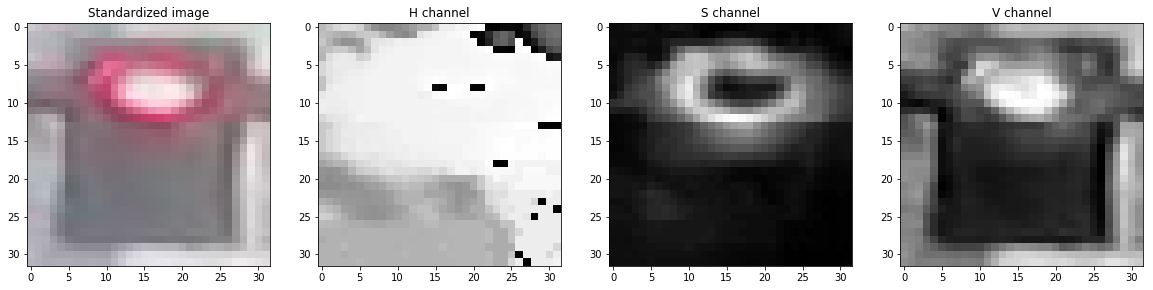

In [7]:
#Visualize
image_num = 0
test_im = Standardized_Train_List[image_num][0]
test_label = Standardized_Train_List[image_num][1]
#convert to hsv
hsv = cv2.cvtColor(test_im, cv2.COLOR_RGB2HSV)
# Print image label
print('Label [red, yellow, green]: ' + str(test_label))
h = hsv[:,:,0]
s = hsv[:,:,1]
v = hsv[:,:,2]
# Plot the original image and the three channels
_, ax = plt.subplots(1, 4, figsize=(20,10))
ax[0].set_title('Standardized image')
ax[0].imshow(test_im)
ax[1].set_title('H channel')
ax[1].imshow(h, cmap='gray')
ax[2].set_title('S channel')
ax[2].imshow(s, cmap='gray')
ax[3].set_title('V channel')
ax[3].imshow(v, cmap='gray')

In [8]:
# create feature
'''
HSV即色相、饱和度、明度（英语：Hue, Saturation, Value），又称HSB，其中B即英语：Brightness。

色相（H）是色彩的基本属性，就是平常所说的颜色名称，如红色、黄色等。
饱和度（S）是指色彩的纯度，越高色彩越纯，低则逐渐变灰，取0-100%的数值。
明度（V），亮度（L），取0-100%。

'''
def create_feature(rgb_image):
    '''
    Basic brightness feature
    rgb_image : a rgb_image
    '''
    hsv = cv2.cvtColor(rgb_image,cv2.COLOR_RGB2HSV)
    
    sum_brightness = np.sum(hsv[:,:,2])
    area = 32*32
    avg_brightness = sum_brightness / area#Find the average
    return avg_brightness

def high_saturation_pixels(rgb_image,threshold=80):
    '''
    Returns average red and green content from high saturation pixels
    Usually, the traffic light contained the highest saturation pixels in the image.
    The threshold was experimentally determined to be 80
    '''
    high_sat_pixels = []
    hsv = cv2.cvtColor(rgb,cv2.COLOR_RGB2HSV)
    for i in range(32):
        for j in range(32):
            if hsv[i][j][1] > threshold:
                high_sat_pixels.append(rgb_image[i][j])
    if not high_sat_pixels:
        return highest_sat_pixel(rgb_image)
    
    sum_red = 0
    sum_green = 0
    for pixel in high_sat_pixels:
        sum_red+=pixel[0]
        sum_green+=pixel[1]
        
    # use sum() instead of manually adding them up
    avg_red = sum_red / len(high_sat_pixels)
    avg_green = sum_green / len(high_sat_pixels)*0.8
    return avg_red,avg_green
def highest_sat_pixel(rgb_image):
    '''
    Finds the highest saturation pixels, and checks if it has a higher green
    or a higher red content
    '''
    hsv = cv2.cvtColor(rgb_image,cv2.COLOR_RGB2HSV)
    s = hsv[:,:,1]
    
    x,y = (np.unravel_index(np.argmax(s),s.shape))
    if rgb_image[x,y,0] > rgb_image[x,y,1]*0.9:
        return 1,0 #red has a higher content
    return 0,1

# Test dataset
接下来我们导入测试集来看看，上述方法的测试精度
上述方法我们实现了：
1.求平均的brightness
2.求red及green的色彩饱和度
有人或许会提出疑问，为啥没有进行yellow的判断，因此我们作出以下的改善
reference [url](http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_colorspaces/py_colorspaces.html?highlight=cv2%20inrange)

In [9]:
def estimate_label(rgb_image,display=False):
    '''
    rgb_image:Standardized RGB image
    '''
    return red_green_yellow(rgb_image,display)
def findNoneZero(rgb_image):
    rows,cols,_ = rgb_image.shape
    counter = 0
    for row in range(rows):
        for col in range(cols):
            pixels = rgb_image[row,col]
            if sum(pixels)!=0:
                counter = counter+1
    return counter
def red_green_yellow(rgb_image,display):
    '''
    Determines the red , green and yellow content in each image using HSV and experimentally
    determined thresholds. Returns a Classification based on the values
    '''
    hsv = cv2.cvtColor(rgb_image,cv2.COLOR_RGB2HSV)
    sum_saturation = np.sum(hsv[:,:,1])# Sum the brightness values
    area = 32*32
    avg_saturation = sum_saturation / area #find average
    
    sat_low = int(avg_saturation*1.3)#均值的1.3倍，工程经验
    val_low = 140
    #Green
    lower_green = np.array([70,sat_low,val_low])
    upper_green = np.array([100,255,255])
    green_mask = cv2.inRange(hsv,lower_green,upper_green)
    green_result = cv2.bitwise_and(rgb_image,rgb_image,mask = green_mask)
    #Yellow
    lower_yellow = np.array([10,sat_low,val_low])
    upper_yellow = np.array([60,255,255])
    yellow_mask = cv2.inRange(hsv,lower_yellow,upper_yellow)
    yellow_result = cv2.bitwise_and(rgb_image,rgb_image,mask=yellow_mask)
    
    # Red 
    lower_red = np.array([150,sat_low,val_low])
    upper_red = np.array([180,255,255])
    red_mask = cv2.inRange(hsv,lower_red,upper_red)
    red_result = cv2.bitwise_and(rgb_image,rgb_image,mask = red_mask)
    if display==True:
        _,ax = plt.subplots(1,5,figsize=(20,10))
        ax[0].set_title('rgb image')
        ax[0].imshow(rgb_image)
        ax[1].set_title('red result')
        ax[1].imshow(red_result)
        ax[2].set_title('yellow result')
        ax[2].imshow(yellow_result)
        ax[3].set_title('green result')
        ax[3].imshow(green_result)
        ax[4].set_title('hsv image')
        ax[4].imshow(hsv)
        plt.show()
    sum_green = findNoneZero(green_result)
    sum_red = findNoneZero(red_result)
    sum_yellow = findNoneZero(yellow_result)
    if sum_red >= sum_yellow and sum_red>=sum_green:
        return [1,0,0]#Red
    if sum_yellow>=sum_green:
        return [0,1,0]#yellow
    return [0,0,1]#green

# Test
接下来我们选择三张图片来看看测试效果
> img_red,img_yellow,img_green

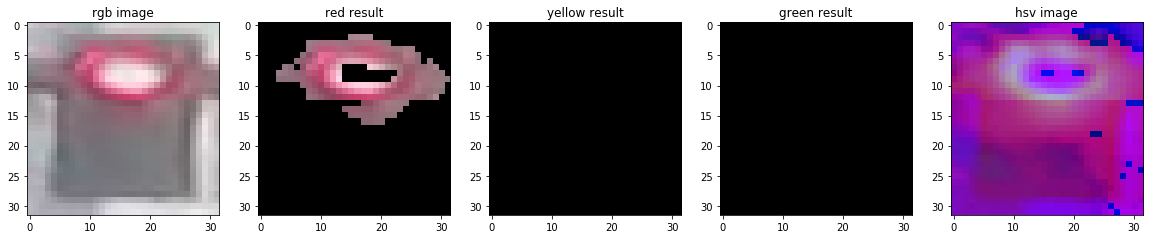

Predict label : [1, 0, 0]
True label: [1, 0, 0]


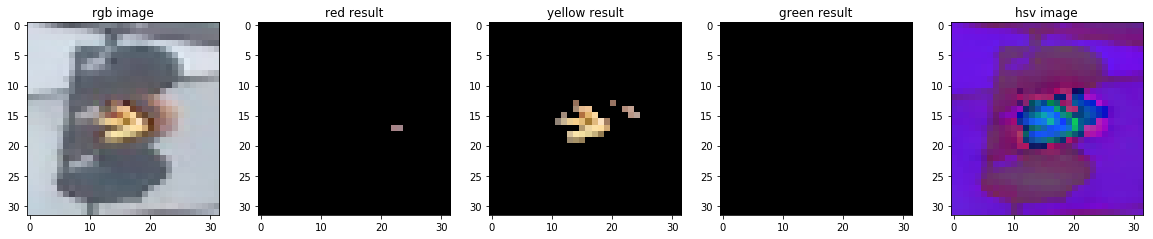

Predict label : [0, 1, 0]
True label: [0, 1, 0]


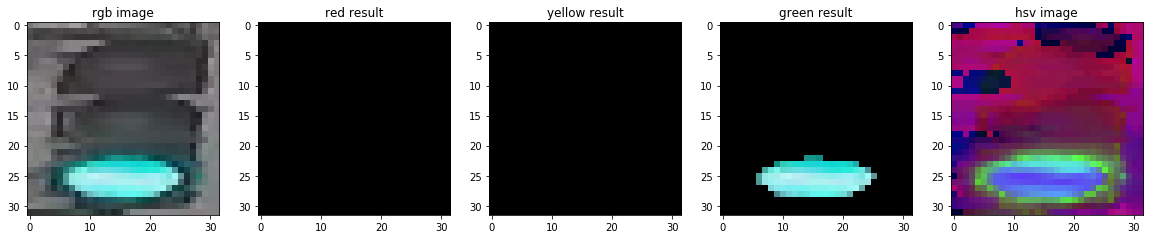

Predict label : [0, 0, 1]
True label: [0, 0, 1]


In [10]:
img_test = [(img_red,'red'),(img_yellow,'yellow'),(img_green,'green')]
standardtest = standardize(img_test)

for img in standardtest:
    predicted_label = estimate_label(img[0],display = True)
    print('Predict label :',predicted_label)
    print('True label:',img[1])

In [11]:
# Using the load_dataset function in helpers.py
# Load test data
TEST_IMAGE_LIST = load_dataset(IMAGE_DIR_TEST)

# Standardize the test data
STANDARDIZED_TEST_LIST = standardize(TEST_IMAGE_LIST)

# Shuffle the standardized test data
random.shuffle(STANDARDIZED_TEST_LIST)

181
9
107


# Determine the Accuracy
接下来我们来看看咱们算法在测试集上的准确率。下面我们实现的代码存储所有的被错分的图片以及它们被预测的结果及真实标签。
这些数据被存储在MISCLASSIFIED.


In [12]:
# COnstructs a list of misclassfied iamges given a list of test images and their labels
# This will throw an assertionerror if labels are not standardized(one hot encode)
def get_misclassified_images(test_images,display=False):
    misclassified_images_labels = []
    #Iterate through all the test images
    #Classify each image  and compare to the true label
    for image in test_images:
        # Get true data
        im = image[0]
        true_label = image[1]
        assert (len(true_label)==3),'This true_label is not the excepted length (3).'
        
        #Get predicted label from your classifier
        predicted_label = estimate_label(im,display=False)
        assert(len(predicted_label)==3),'This predicted_label is not the excepted length (3).'
        
        #compare true and predicted labels
        if(predicted_label!=true_label):
            #if these labels are ot equal, the image  has been misclassified
            misclassified_images_labels.append((im,predicted_label,true_label))
    # return the list of misclassified [image,predicted_label,true_label] values
    return misclassified_images_labels
# Find all misclassified images in a given test set
MISCLASSIFIED = get_misclassified_images(STANDARDIZED_TEST_LIST,display=False)
#Accuracy calcuations
total = len(STANDARDIZED_TEST_LIST)
num_correct = total-len(MISCLASSIFIED)
accuracy = num_correct / total
print('Accuracy:'+str(accuracy))
print('Number of misclassfied images = '+str(len(MISCLASSIFIED))+' out of '+str(total))

Accuracy:0.9797979797979798
Number of misclassfied images = 6 out of 297
